# 04 – Sentiment & Emotion Regressions

Study how FinBERT sentiment scores and emotion probabilities relate to post-earnings-call returns.

## Imports & configuration

In [1]:
from __future__ import annotations

import json
import logging
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResultsWrapper

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

sns.set_theme(style='whitegrid')
pd.options.display.float_format = '{:,.4f}'.format
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

DATA_DIR = Path('data')
OUTPUT_DIR = Path('output')
FIG_DIR = OUTPUT_DIR / 'fig'
REG_DIR = OUTPUT_DIR / 'regression'
FIG_DIR.mkdir(parents=True, exist_ok=True)
REG_DIR.mkdir(parents=True, exist_ok=True)

FINBERT_RETURNS_PATHS = [OUTPUT_DIR / 'finbert_sentiment_returns.parquet', OUTPUT_DIR / 'sentiment_returns.csv']
EMOTION_RETURNS_PATHS = [OUTPUT_DIR / 'emotion_returns.parquet', OUTPUT_DIR / 'emotion_returns.csv']
COMBINED_SAVE_PATH = REG_DIR / 'combined_sentiment_returns.parquet'

RETURN_HORIZONS = ['return_1d', 'return_3d', 'return_5d']
TRAIN_SIZE = 0.75
RANDOM_STATE = 42


In [2]:
matplotlib_dark_theme = True

if matplotlib_dark_theme:
	plt.rcParams.update({
		# Fonts and text
		"text.color": "white",
		"axes.labelcolor": "white",
		"xtick.color": "white",
		"ytick.color": "white",

		# Axes/spines
		"axes.edgecolor": "white",  # borders
		"xtick.color": "white",
		"ytick.color": "white",
		"grid.color": "white",

		# Background
		"figure.facecolor": "none",  # transparent
		"axes.facecolor": "none"
	})

## Helper functions

In [3]:
def read_table(paths: List[Path]) -> pd.DataFrame:
    for path in paths:
        if path.exists():
            logging.info("Loading %s", path)
            if path.suffix.lower() == ".parquet":
                return pd.read_parquet(path)
            if path.suffix.lower() == ".csv":
                return pd.read_csv(path)
    raise FileNotFoundError(f"None of the paths found: {paths}")

def ensure_columns(df: pd.DataFrame, cols: Iterable[str]) -> List[str]:
    return [col for col in cols if col in df.columns]

def safe_mean(df: pd.DataFrame, cols: Iterable[str]) -> Optional[pd.Series]:
    valid = [col for col in cols if col in df.columns]
    if not valid:
        return None
    return df[valid].mean(axis=1)

def add_emotion_composites(df: pd.DataFrame) -> pd.DataFrame:
    negative_cols = [
        "p_anger_wmean_emotion",
        "p_disgust_wmean_emotion",
        "p_fear_wmean_emotion",
        "p_sadness_wmean_emotion",
    ]
    arousal_cols = [
        "p_surprise_wmean_emotion",
        "p_anger_wmean_emotion",
        "p_fear_wmean_emotion",
    ]
    joy_col = "p_joy_wmean_emotion"
    neutral_col = "p_neutral_wmean_emotion"

    neg_mean = safe_mean(df, negative_cols)
    if neg_mean is not None:
        df["emotion_negative_mean"] = neg_mean
    if joy_col in df.columns and neg_mean is not None:
        df["emotion_valence"] = df[joy_col] - df["emotion_negative_mean"]
    if joy_col in df.columns and neutral_col in df.columns:
        df["emotion_joy_over_neutral"] = df[joy_col] - df[neutral_col]
    arousal_mean = safe_mean(df, arousal_cols)
    if arousal_mean is not None:
        df["emotion_arousal"] = arousal_mean
    return df

def single_variable_ols(y: pd.Series, x: pd.Series) -> Tuple[float, float, float, int]:
    mask = y.notna() & x.notna()
    if mask.sum() < 50:
        return np.nan, np.nan, np.nan, mask.sum()
    X = sm.add_constant(x[mask])
    model = sm.OLS(y[mask], X).fit()
    coef = model.params.get(x.name, np.nan)
    tval = model.tvalues.get(x.name, np.nan)
    r2 = model.rsquared
    return coef, tval, r2, mask.sum()

def collect_single_var_results(df: pd.DataFrame, features: Iterable[str], target: str) -> pd.DataFrame:
    rows = []
    y = df[target]
    for feature in features:
        if feature not in df.columns:
            continue
        coef, tval, r2, n = single_variable_ols(y, df[feature])
        rows.append({"feature": feature, "coef": coef, "t": tval, "r2": r2, "n": n})
    res = pd.DataFrame(rows)
    if res.empty:
        return res
    res["abs_t"] = res["t"].abs()
    return res.sort_values("abs_t", ascending=False)

def run_ols(df: pd.DataFrame, target: str, features: Iterable[str]) -> RegressionResultsWrapper:
    cols = [f for f in features if f in df.columns]
    if not cols:
        raise ValueError("No valid features supplied")
    data = df[[target] + cols].dropna()
    X = sm.add_constant(data[cols])
    y = data[target]
    return sm.OLS(y, X).fit()

def summarise_model(model: RegressionResultsWrapper, target: str, label: str) -> Dict[str, float]:
    return {
        "model": label,
        "target": target,
        "n_obs": int(model.nobs),
        "r2": model.rsquared,
        "adj_r2": model.rsquared_adj,
        "rmse": np.sqrt(model.mse_resid),
    }


## Load & merge datasets

In [4]:
finbert_df = read_table(FINBERT_RETURNS_PATHS)
emotion_df = read_table(EMOTION_RETURNS_PATHS)

id_cols = ['symbol', 'rdq']
for df in (finbert_df, emotion_df):
    if 'rdq' in df.columns:
        df['rdq'] = pd.to_datetime(df['rdq'])
        df['year'] = df['rdq'].dt.year
        df['quarter'] = df['rdq'].dt.quarter

combined = finbert_df.merge(emotion_df, on=id_cols, how='inner', suffixes=('_finbert', '_emotion'))
combined = add_emotion_composites(combined)
combined['event_year'] = combined['rdq'].dt.year

available_return_cols = [col for col in combined.columns if col.startswith('return_')]
for horizon in RETURN_HORIZONS:
    if horizon not in combined.columns:
        candidates = [c for c in available_return_cols if c.startswith(horizon)]
        if candidates:
            combined[horizon] = combined[candidates].bfill(axis=1).iloc[:, 0]

# drop residual duplicate return columns
for col in list(combined.columns):
    if any(col.startswith(f'{h}_') for h in RETURN_HORIZONS):
        if col not in RETURN_HORIZONS:
            combined.drop(columns=col, inplace=True)

combined.to_parquet(COMBINED_SAVE_PATH, index=False)
combined.head()

INFO: Loading output/finbert_sentiment_returns.parquet
INFO: Loading output/emotion_returns.parquet


,symbol,rdq,p_positive_wmean,p_positive_std,p_positive_q95,p_positive_q05,p_negative_wmean,p_negative_std,p_negative_q95,p_negative_q05,...,year_emotion,quarter_emotion,emotion_negative_mean,emotion_valence,emotion_joy_over_neutral,emotion_arousal,event_year,return_1d,return_3d,return_5d
0,FC,2010-01-07,0.4671,0.3399,0.9441,0.0526,0.1484,0.2435,0.7758,0.0114,...,2010,1,0.0072,0.1831,-0.5228,0.0275,2010,-0.0094,-0.0204,-0.0330
1,WDFC,2010-01-11,0.3985,0.3199,0.8210,0.0122,0.3394,0.3860,0.9686,0.0108,...,2010,1,0.0156,0.0820,-0.7046,0.0199,2010,-0.0056,-0.0074,0.0117
2,COHR,2010-01-19,0.6014,0.2973,0.9493,0.1853,0.0574,0.1060,0.2216,0.0115,...,2010,1,0.0060,0.1932,-0.4867,0.0340,2010,-0.0075,-0.0540,-0.0998
3,PH,2010-01-19,0.3259,0.2972,0.9315,0.0166,0.3073,0.3491,0.9617,0.0192,...,2010,1,0.0120,0.0388,-0.8091,0.0186,2010,-0.0125,-0.0614,-0.0783
4,WOLF,2010-01-19,0.3508,0.3118,0.9199,0.0722,0.0369,0.0277,0.0989,0.0101,...,2010,1,0.0100,0.0217,-0.8389,0.0242,2010,-0.0372,-0.0579,-0.0496


### Feature lists

In [5]:
# finbert_base = [
#     'p_positive_wmean_finbert','p_negative_wmean_finbert','p_neutral_wmean_finbert','net_pos_finbert',
#     'prepared_net_pos_finbert','qa_net_pos_finbert','delta_prepared_qa_net_pos_finbert',
#     'mgmt_net_pos_finbert','analyst_net_pos_finbert','delta_mgmt_analyst_net_pos_finbert',
#     'entropy_wmean_finbert','n_tokens_total_finbert'
# ]
finbert_base = [  # if present in the prev data
    'p_positive_wmean',
    'p_negative_wmean',
    'p_neutral_wmean',
    'net_pos',
    'prepared_net_pos',
    'qa_net_pos',
    'delta_prepared_qa_net_pos',
    'mgmt_net_pos',
    'analyst_net_pos',
    'delta_mgmt_analyst_net_pos',
    'entropy_wmean',
    'n_tokens_total',
    'total_sentences',         
]
finbert_features = ensure_columns(combined, finbert_base)

emotion_prob_cols = [
    'p_anger_wmean_emotion','p_disgust_wmean_emotion','p_fear_wmean_emotion','p_joy_wmean_emotion',
    'p_neutral_wmean_emotion','p_sadness_wmean_emotion','p_surprise_wmean_emotion'
]
emotion_composites = ensure_columns(combined, ['emotion_negative_mean','emotion_valence','emotion_joy_over_neutral','emotion_arousal'])
emotion_features = ensure_columns(combined, emotion_prob_cols + emotion_composites + ['entropy_wmean_emotion','n_tokens_total_emotion'])
combined_features = list(dict.fromkeys(finbert_features + emotion_features))
logging.info('FinBERT features: %s', finbert_features)
logging.info('Emotion features: %s', emotion_features)

INFO: FinBERT features: ['p_positive_wmean', 'p_negative_wmean', 'p_neutral_wmean', 'entropy_wmean']
INFO: Emotion features: ['p_anger_wmean_emotion', 'p_disgust_wmean_emotion', 'p_fear_wmean_emotion', 'p_joy_wmean_emotion', 'p_neutral_wmean_emotion', 'p_sadness_wmean_emotion', 'p_surprise_wmean_emotion', 'emotion_negative_mean', 'emotion_valence', 'emotion_joy_over_neutral', 'emotion_arousal', 'entropy_wmean_emotion', 'n_tokens_total_emotion']


## Exploratory diagnostics

PosixPath('output/fig/sentiment_emotion_corr_matrix.png')

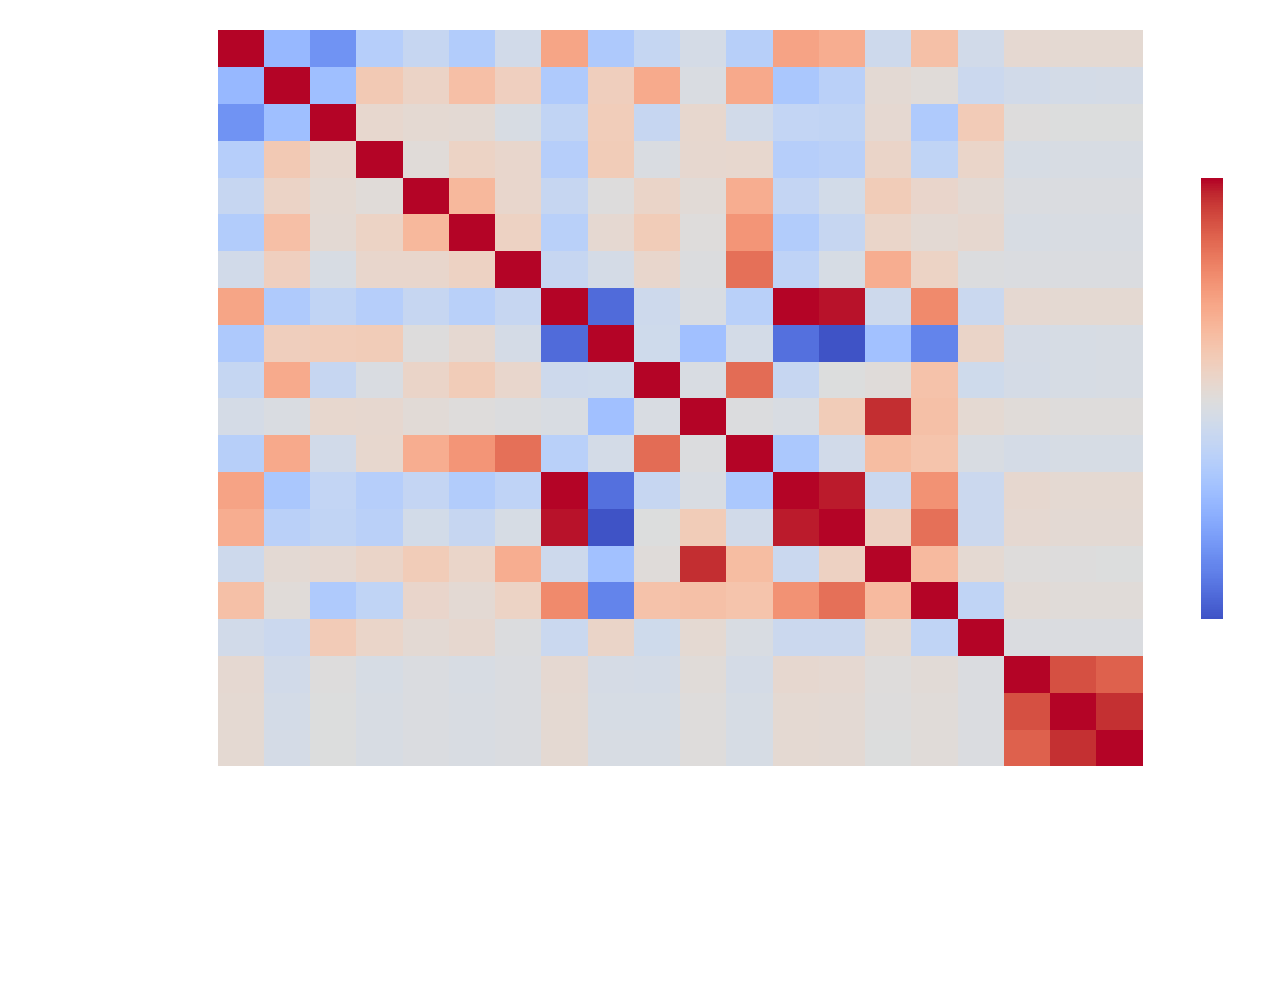

In [6]:
corr_cols = ensure_columns(combined, finbert_features + emotion_features + RETURN_HORIZONS)
corr_matrix = combined[corr_cols].corr()
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, ax=ax, cbar_kws={'shrink':0.6})
ax.set_title('Correlation matrix – sentiment/emotion vs returns')
fig.tight_layout()
fig_path = FIG_DIR / 'sentiment_emotion_corr_matrix.png'
fig.savefig(fig_path, dpi=150)
fig_path

### Single-variable regressions

In [7]:
single_results = {}
for horizon in RETURN_HORIZONS:
    finbert_res = collect_single_var_results(combined, finbert_features, horizon)
    emotion_res = collect_single_var_results(combined, emotion_features, horizon)
    finbert_res.to_csv(REG_DIR / f'finbert_single_{horizon}.csv', index=False)
    emotion_res.to_csv(REG_DIR / f'emotion_single_{horizon}.csv', index=False)
    single_results[(horizon,'FinBERT')] = finbert_res
    single_results[(horizon,'Emotion')] = emotion_res
    display(finbert_res.head(5))
    display(emotion_res.head(5))

,feature,coef,t,r2,n,abs_t
1,p_negative_wmean,-0.0547,-21.8640,0.0076,62822,21.8640
0,p_positive_wmean,0.0360,17.4037,0.0048,62822,17.4037
3,entropy_wmean,-0.0437,-11.2245,0.0020,62822,11.2245
2,p_neutral_wmean,0.0013,0.6332,0.0000,62822,0.6332


,feature,coef,t,r2,n,abs_t
8,emotion_valence,0.0669,18.1416,0.0052,62822,18.1416
3,p_joy_wmean_emotion,0.0652,17.2747,0.0047,62822,17.2747
9,emotion_joy_over_neutral,0.0311,16.2825,0.0042,62822,16.2825
7,emotion_negative_mean,-0.7138,-15.5956,0.0039,62822,15.5956
5,p_sadness_wmean_emotion,-0.3108,-15.5044,0.0038,62822,15.5044


,feature,coef,t,r2,n,abs_t
1,p_negative_wmean,-0.0565,-17.9937,0.0051,62822,17.9937
0,p_positive_wmean,0.0375,14.4741,0.0033,62822,14.4741
3,entropy_wmean,-0.0516,-10.5730,0.0018,62822,10.5730
2,p_neutral_wmean,0.0010,0.3747,0.0000,62822,0.3747


,feature,coef,t,r2,n,abs_t
8,emotion_valence,0.0727,15.7028,0.0039,62822,15.7028
3,p_joy_wmean_emotion,0.0710,14.9938,0.0036,62822,14.9938
9,emotion_joy_over_neutral,0.0330,13.7945,0.0030,62822,13.7945
7,emotion_negative_mean,-0.7471,-13.0114,0.0027,62822,13.0114
5,p_sadness_wmean_emotion,-0.3049,-12.1216,0.0023,62822,12.1216


,feature,coef,t,r2,n,abs_t
1,p_negative_wmean,-0.0553,-16.3950,0.0043,62822,16.3950
0,p_positive_wmean,0.0408,14.6708,0.0034,62822,14.6708
3,entropy_wmean,-0.0487,-9.2851,0.0014,62822,9.2851
2,p_neutral_wmean,-0.0033,-1.1626,0.0000,62822,1.1626


,feature,coef,t,r2,n,abs_t
8,emotion_valence,0.0744,14.9782,0.0036,62822,14.9782
3,p_joy_wmean_emotion,0.0728,14.3084,0.0032,62822,14.3084
9,emotion_joy_over_neutral,0.0334,12.9784,0.0027,62822,12.9784
7,emotion_negative_mean,-0.7606,-12.3359,0.0024,62822,12.3359
5,p_sadness_wmean_emotion,-0.2966,-10.9790,0.0019,62822,10.9790


### Multivariate OLS models

In [8]:
ols_models = {}
ols_summary_rows = []
for horizon in RETURN_HORIZONS:
    finbert_model = run_ols(combined, horizon, finbert_features)
    emotion_model = run_ols(combined, horizon, emotion_features)
    combined_model = run_ols(combined, horizon, combined_features)
    ols_models[(horizon,'FinBERT')] = finbert_model
    ols_models[(horizon,'Emotion')] = emotion_model
    ols_models[(horizon,'Combined')] = combined_model
    finbert_model.save(REG_DIR / f'ols_finbert_{horizon}.pickle')
    emotion_model.save(REG_DIR / f'ols_emotion_{horizon}.pickle')
    combined_model.save(REG_DIR / f'ols_combined_{horizon}.pickle')
    ols_summary_rows.append(summarise_model(finbert_model, horizon, 'FinBERT'))
    ols_summary_rows.append(summarise_model(emotion_model, horizon, 'Emotion'))
    ols_summary_rows.append(summarise_model(combined_model, horizon, 'Combined'))
pd.DataFrame(ols_summary_rows)

,model,target,n_obs,r2,adj_r2,rmse
0,FinBERT,return_1d,62822,0.0092,0.0091,0.0617
1,Emotion,return_1d,62822,0.0094,0.0092,0.0617
2,Combined,return_1d,62822,0.0128,0.0126,0.0616
3,FinBERT,return_3d,62822,0.0065,0.0064,0.0775
4,Emotion,return_3d,62822,0.0062,0.0060,0.0775
5,Combined,return_3d,62822,0.0086,0.0084,0.0774
6,FinBERT,return_5d,62822,0.0057,0.0056,0.0833
7,Emotion,return_5d,62822,0.0054,0.0053,0.0833
8,Combined,return_5d,62822,0.0074,0.0072,0.0832


### Coefficient plots (combined model)

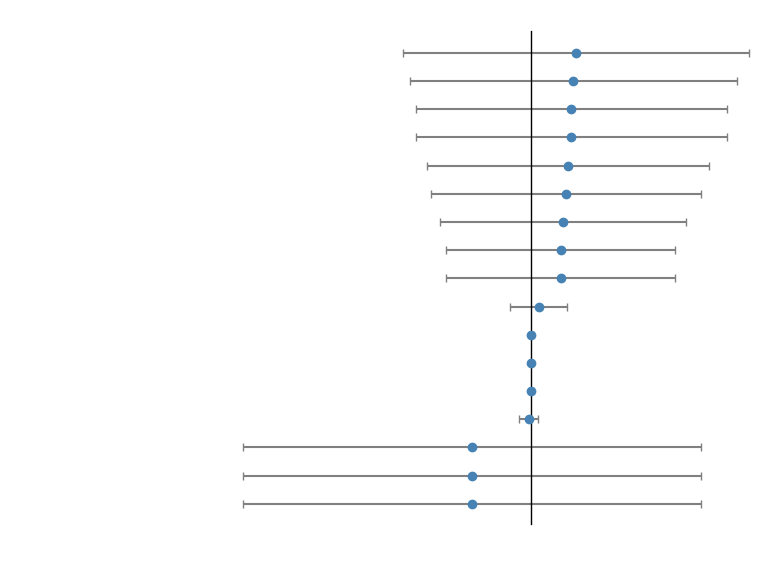

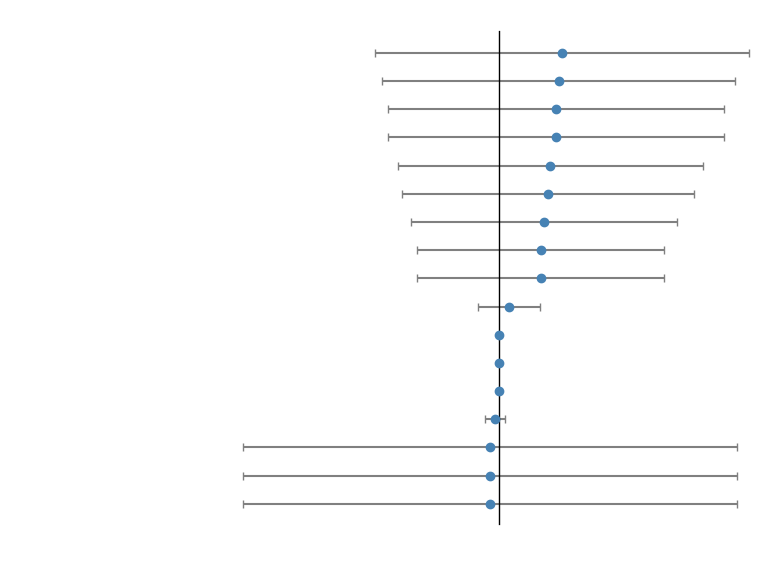

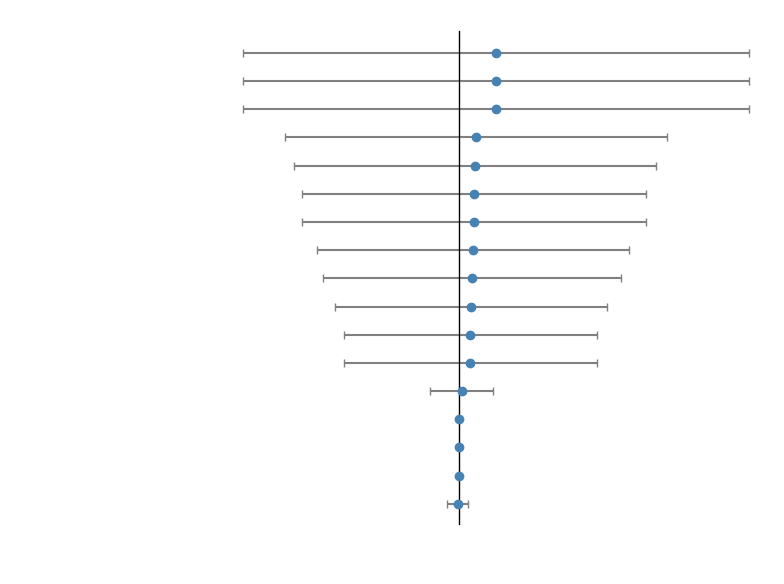

In [9]:
for horizon in RETURN_HORIZONS:
    model = ols_models[(horizon,'Combined')]
    params = model.params.drop('const')
    conf_int = model.conf_int().drop(index='const')
    df_plot = pd.DataFrame({'coef': params, 'lower': conf_int[0], 'upper': conf_int[1]}).sort_values('coef')
    fig, ax = plt.subplots(figsize=(8, max(6, len(df_plot)*0.3)))
    ax.errorbar(df_plot['coef'], df_plot.index, xerr=[df_plot['coef']-df_plot['lower'], df_plot['upper']-df_plot['coef']], fmt='o', color='steelblue', ecolor='gray', capsize=3)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title(f'Combined coefficients – {horizon}')
    ax.set_xlabel('Coefficient')
    fig.tight_layout()
    fig.savefig(FIG_DIR / f'combined_coefficients_{horizon}.png', dpi=150)
    # plt.close(fig)

## Save summaries

In [10]:
ols_summary_df = pd.DataFrame(ols_summary_rows)
ols_summary_df.to_csv(REG_DIR / 'ols_model_summary.csv', index=False)